# Temporal and spatial analysis of the characteristics of well-performing movies

## Table of Contents
* [Load the reformatted data](#chapter1)
* [Exploratory data analysis: distribution of the data](#chapter2)
    * [Languages](#section_2_1)
    * [Countries](#section_2_2)
    * [Genres](#section_2_3)
    * [Release date](#section_2_4)
    * [Runtime](#section_2_5)
    * [Movie name](#section_2_6)
* [Merge CMU dataset with IMDb dataset](#chapter3)
    * [Getting the matching Freebase ID and IMDb ID](#section_3_1)
    * [Merging CMU dataset and FreebaseToIMDb dataset](#section_3_2)
    * [Merging CMU dataset and IMDb dataset](#section_3_3)
* [Compute correlation beteen two categorical variables](#chapter4)
    * [Function definitions](#section_4_1)
        * [Format the data](#sub_section_4_1_1)
        * [Compute the p-value for the H0: "var1 and var2 are independent"](#sub_section_2_3_1)
    * [P-value computations](#section_4_2)
        * [Languages vs Countries](#sub_section_4_2_1)
        * [Languages vs Genres](#sub_section_4_2_2)
        * [Countries vs Genres](#sub_section_4_2_3)

In [1]:
import numpy as np
import pandas as pd
import ast
import scipy.stats as ss

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pylab as pl

import itertools
import unidecode
from collections import Counter

import os

import requests

'''Download the files from the following folder and place them under datasets/moviedata/
https://drive.google.com/drive/folders/1mJsTvP3VfzLWgV_zlO1S9xiWyrTJlNG4?usp=sharing
'''

PATH_IN = './datasets/moviedata/'

## 1. Load the reformatted data <a class="anchor" id="chapter1"></a>

In [2]:
'''
    Load the data from the saved reformatted dataset "formatted_movie_metadata.csv".
    Details on how we obtained this dataset can be found in the "dataProcessing" notebook.
'''
fname = os.path.join(PATH_IN, 'formatted_movie_metadata.csv')
df = pd.read_csv(fname)

# Remove the '-' from the release date
# eg convert 2007-09-14 to 20070914
df['Release date'] = [''.join(x.split('-')) if pd.isna(x)==False else x for x in df['Release date']]

# Convert string of a list, to a list
# eg convert '['English', 'French']' to ['English', 'French']
df['Languages'] = df['Languages'].apply(lambda x: ast.literal_eval(x))
df['Countries'] = df['Countries'].apply(lambda x: ast.literal_eval(x))
df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x))

## 2. Exploratory data analysis: distribution of the data <a class="anchor" id="chapter2"></a>

In [3]:
def categorical_var_histogram(var_name):
    '''Histogram of the 10 most frequent values for the categorical variables'''
    
    # Concatenate all elements of the dataseries to obtain a single list (instead of a list of list)
    var_list = list(itertools.chain.from_iterable(df[var_name]))

    # Compute the number of occurences of each values
    # (-> dictionnary containing values and associated number of occurences)
    frequencies = Counter(var_list)

    # Sort by most frequent values
    frequencies = [[key, int(val)] for key, val in frequencies.items()]
    frequencies.sort(key=lambda x: -x[1])

    # Compute the number of entries corresponding to the 10 most frequent values
    num_entries = sum(x[1] for x in frequencies[:10])

    # Select the entries corresponding to the 10 most frequent values
    var_list.sort(key=Counter(var_list).get, reverse=True)
    var_list = pd.Series(var_list[:num_entries])

    # Plot the histogram with the y-axis in log-scale
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    hist = var_list.value_counts().plot(kind='bar', color=default_colors[:10])
    pl.xlabel(var_name, fontsize=15)
    pl.xticks(fontsize=12)
    pl.ylabel("Number of occurrences", fontsize=15)
    pl.yticks(fontsize=12)
    pl.yscale('log')
    pl.title(f'Bar plot of the 10 most frequent {var_name.lower()}', fontsize=15)
    plt.show()
    
    return frequencies

In [4]:
'''Alternative to the histogram: pie chart'''

def categorical_var_piechart(frequencies):
    
    # Format the ratio displayed inside the chart
    def autopct_format(x):
        return f'{int(x)}%'

    labels = np.array(frequencies)[:,0]
    sizes = np.array(frequencies)[:,1].astype(int)

    # Group less frequent values together
    other_label = 'Other'
    other_size = np.sum(sizes[12:])

    reduced_labels = np.append(labels[:12], other_label)
    reduced_sizes = np.append(sizes[:12], other_size)

    # Plot the pie chart
    plt.figure(figsize=(9,9))
    plt.pie(reduced_sizes, labels=reduced_labels, autopct=lambda x: autopct_format(x))
    plt.show()

### a) Language <a class="anchor" id="section_2_1"></a>

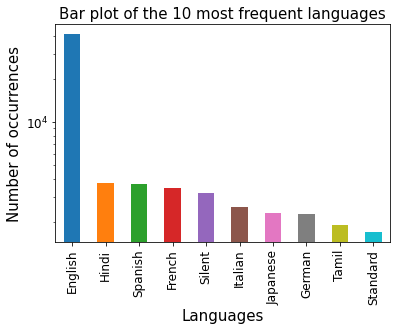

In [5]:
freq_languages = categorical_var_histogram('Languages')

To understand the distribution of the languages that are used in the movies of the CMU dataset, we decided to visualize the data. With this in mind, we created a bar plot, representing the number of occurences of the 10 most used languages. From this plot, we can notice that English is the prevailing language.

Due to the big difference between the number of times English is used compared to other languages, we used a logarithmin y-axis. This enables us to observe the differences amoung other languages. For example, we can notice that Hindi is used a lot more frequently than Tamil.

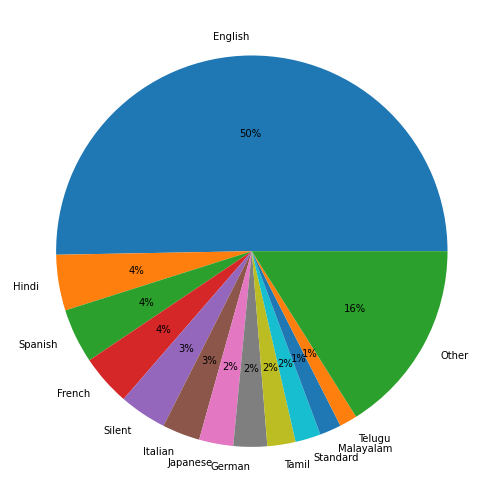

In [6]:
categorical_var_piechart(freq_languages)

To get more precise, we also represented this data in the form of a pie chart. This show that indeed, English is being used in 50% of the cases.

### b) Countries <a class="anchor" id="section_2_2"></a>

To analyze the distribution of the countries, we carry out a similar analysis.

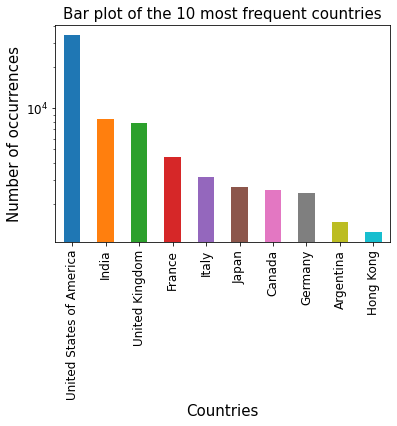

In [7]:
freq_countries = categorical_var_histogram('Countries')

As previously, we used a logarithmic y-axis. Unlike the language distribution, here more than one country has significant occurrence. From what we can observe, movies where a certain language is used are usually shot in a country with the same official language. This assumption will be investigated later on, when a correlation analysis between Language and Country is performed.

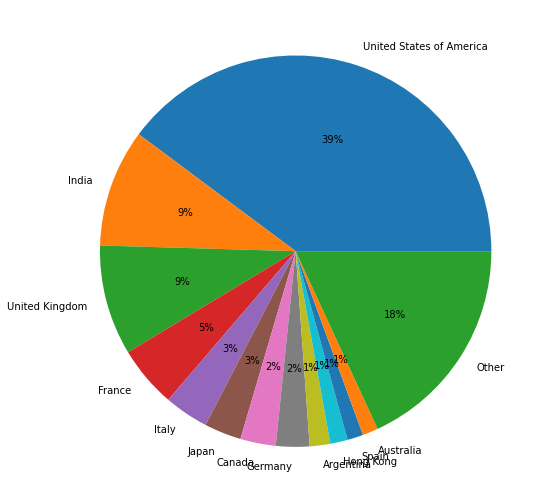

In [8]:
categorical_var_piechart(freq_countries)

From the pie chart we can clearly observe that 4 countries add up to around 65% of the total. This implies that the majority of movies are shot in only a small subset of the total number of countries.

### c) Genres <a class="anchor" id="section_2_3"></a>

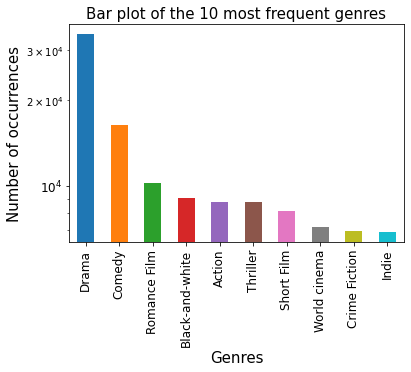

In [9]:
freq_genres = categorical_var_histogram('Genres')

From the barplot, we can clearly distinguish that 'drama' is the leading genre.

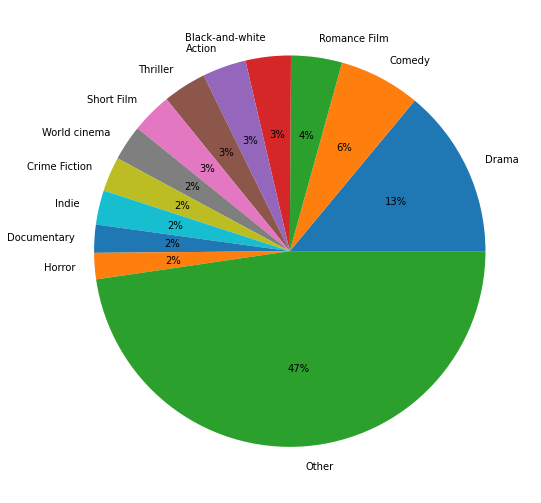

In [10]:
categorical_var_piechart(freq_genres)

 The pie chart let us confirm that 'drama' is the major genre used in movies, but it is not predominant. As we can see, many genres contribute to the total amount unlike the "Language" category.

### d) Release date <a class="anchor" id="section_2_4"></a>
In this section we will investigate the distributon of movies based on their release date.
First, we will transform the "Release date" column. We will only keep the year in order to make the date homogenious (as some movies miss month and day). Following, we convert it into an integer and use a line plot in order to visualize the distribution. 

In [11]:
'''Extract the year from the release date'''
df_date = df.copy()
df['Release date'].str[:4]

0        2001
1        2000
2        1988
3        1987
4        1983
         ... 
81736    2011
81737    2011
81738    1972
81739    1992
81740    2002
Name: Release date, Length: 81741, dtype: object

In [12]:
'''Convert string to int'''

# Remove the Nan values
df_date = df_date[pd.isna(df_date['Release date'])==False]

df_date['Release year'] = df_date['Release date'].str[:4]


df_date['Release date'] = df_date['Release date'].astype(int)


In [13]:
df_date

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres,Release year
0,975900,/m/03vyhn,Ghosts of Mars,20010824,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000
2,28463795,/m/0crgdbh,Brun bitter,19880000,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988
3,9363483,/m/0285_cd,White Of The Eye,19870000,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987
4,261236,/m/01mrr1,A Woman in Flames,19830000,106.0,[German],[Germany],[Drama],1983
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,20110319,120.0,[English],[United States of America],[Drama],2011
81737,34980460,/m/0g4pl34,Knuckle,20110121,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011
81738,9971909,/m/02pygw1,Another Nice Mess,19720922,66.0,[English],[United States of America],"[Satire, Comedy]",1972
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,19920521,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992


In [14]:
'''Compute the range of the values'''
print(f"The oldest movie from the dataset was released in {df_date['Release year'].min()}.")
print(f"The more recent movie from the dataset was released in {df_date['Release year'].max()}.")

The oldest movie from the dataset was released in 1010.
The more recent movie from the dataset was released in 2016.


In [15]:
groupby_year = df_date.groupby('Release year').count()

In [16]:
groupby_year

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres
Release year,,,,,,,,
1010,1,1,1,1,1,1,1,1
1888,1,1,1,1,1,1,1,1
1889,1,1,1,1,0,1,1,1
1890,2,2,2,2,0,2,2,2
1891,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...
2012,1194,1194,1194,1194,610,1194,1194,1194
2013,164,164,164,164,21,164,164,164
2014,17,17,17,17,0,17,17,17


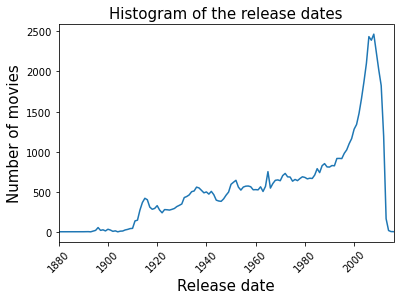

In [17]:
'''Plot the histogram'''
hist = plt.plot(groupby_year['Wikipedia ID'].index.astype(int), groupby_year['Wikipedia ID'])
plt.xlabel("Release date", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.xlim(1880, 2016)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.title('Histogram of the release dates', fontsize=15)
plt.show()

We can observe the drastic increase in the amount of movies produced in the past 40 years. This is most likely caused by the technological advancements which enabled the movie industry to become ubiquitous. Due to this, it is expected that results from this time period will be a better representation of the real world when conducting a temporal analysis.

### e) Runtime <a class="anchor" id="section_2_5"></a>
In this section we will analyse the runtime of the movies.

In [18]:
df['Runtime'].head(3)

0    98.0
1    95.0
2    83.0
Name: Runtime, dtype: float64

In [19]:
'''Remove the Nan values'''
df_runtime = df['Runtime'][pd.isna(df['Runtime'])==False]

In [20]:
'''Compute the range of the values'''
print(f'The shortes movie from the dataset lasts {int(df_runtime.min())} minutes.')
print(f'The longuest movie from the dataset lasts {int(df_runtime.max())} minutes.')

The shortes movie from the dataset lasts 0 minutes.
The longuest movie from the dataset lasts 1079281 minutes.


<function matplotlib.pyplot.show(close=None, block=None)>

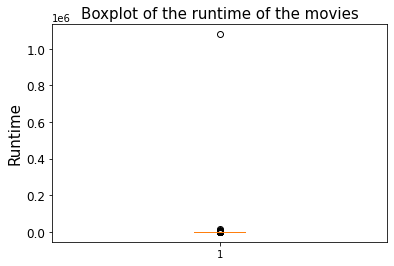

In [21]:
plt.figure(figsize=(6,4))
plt.boxplot(df_runtime)
plt.ylabel('Runtime', fontsize=15)
plt.yticks(fontsize=12)
plt.title('Boxplot of the runtime of the movies', fontsize=15)
plt.show

We observe an outlier. Assuming that runtimes over 5h (300min) are invalid, we decide to remove them.

In [22]:
df

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,20010824,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,19880000,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,19870000,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,19830000,106.0,[German],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,20110319,120.0,[English],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,20110121,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,19720922,66.0,[English],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,19920521,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [23]:
'''Remove outliers/extreme values'''
df_runtime = df_runtime[df_runtime<300]

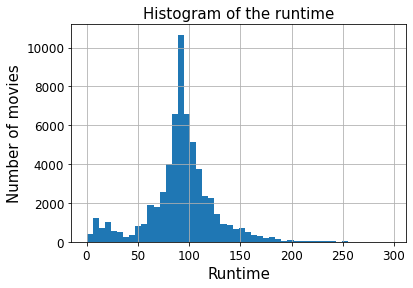

In [24]:
'''Plot the histogram'''
hist_runtime = df_runtime.hist(figsize=(6,4), bins=50)
pl.xlabel("Runtime", fontsize=15)
pl.xticks(fontsize=12)
pl.ylabel("Number of movies", fontsize=15)
pl.yticks(fontsize=12)
pl.title('Histogram of the runtime', fontsize=15)
plt.show()

As we can observe, the most common movie runtime falls around the hour and a half mark. However, we can see 2 separate peaks in the histogram, which leads us to the assumption that movies can be categorized into types based on their runtime and futher investigation will have to be conducted.

### f) Movie name <a class="anchor" id="section_2_6"></a>

Due to the fact that revenue will not be used as a measurement of success, we have to identify a way to properly merge the CMU dataset with the IMDb ratings dataset in order to make use of the ratings and number of votes as our success measurement. Here we investigate if it would be possible to use movie `names` and `release date` as key indentifiers when merging.

In [25]:
df['Name'].value_counts()

Alice in Wonderland                           17
Macbeth                                       16
Les Misérables                                13
A Christmas Carol                             13
Hero                                          12
                                              ..
The Eyes of Thailand                           1
Note by Note: The Making of Steinway L1037     1
Sakthi                                         1
The Adventurer of Tortuga                      1
Spliced                                        1
Name: Name, Length: 75478, dtype: int64

There are 75478 unique names among the 81741 movie titles. We can see that some movies have the same name, thus the `names` can not be used as identifiers of movies.

In [26]:
df[['Name', 'Release date']].value_counts()

Name                             Release date
Sangam                           19640000        2
Jeepers Creepers                 19390000        2
Durango                          19990425        2
Buck Rogers in the 25th Century  19790330        2
The Job                          20030000        2
                                                ..
Hideaway                         19950303        1
Hide-Out                         19340000        1
Hide and go shriek               19880000        1
Hide and Shriek                  19380618        1
春田花花同學會                          20060126        1
Length: 74803, dtype: int64

Movies are not even uniquely defined by their (movie name, release date). Two movies can have the same name AND release date.

## 3. Merge CMU dataset with IMDB dataset <a class="anchor" id="chapter3"></a>

### a) Getting the matching Freebase ID and IMDb ID <a class="anchor" id="section_3_1"></a>

From the exploratory data analysis, we concluded that we could not merge the CMU dataset with the IMDb dataset based on the titles or the release dates of the movies as they do not uniquely define them.

Thus, we make use of Wikidata Query Service in order to get matching Freebase ID with IMDb ID. Initially, we tried to use the `request` and `pywikibot` libraries in order to fetch the wiki ids (because the wikipedia ids in the CMU dataset are not valid) of the movies and then find the according IMDb id. Unfortunately, due to API limitations (around 30 requests per 1 minute), we decided to use a query, specified below, which fetches the entire dataset, provided by the Wikidata Query Service. This way we can enhance our CMU dataset by first merging it with the obtained dataset from the query. What would follow is a merge with the IMDb ratings dataset.

We used the following query to obtain the dataset containt the Freebase ID to IMDb ID matching:

https://query.wikidata.org/#PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%3Fitem%20%3FfreebaseID%20%3FimdbID%0AWHERE%20%7B%0A%20%20%3Fitem%20wdt%3AP31%2Fwdt%3AP279%2a%20wd%3AQ11424.%0A%20%20%3Fitem%20wdt%3AP646%20%3FfreebaseID.%0A%20%20%3Fitem%20wdt%3AP345%20%3FimdbID.%0A%20%20%7D

where
* **P646**: identifier for a page in the `Freebase` database (format: "/m/0" followed by 2 to 7 characters)
* **P345**: identifier for the `IMDb` (with prefix 'tt', 'nm', 'co', 'ev', 'ch' or 'ni')

### b) Merging CMU dataset and FreebaseToIMDb dataset <a class="anchor" id="section_3_2"></a>

In [27]:
freebase_to_imdb_filename = os.path.join(PATH_IN, 'freebaseID_imdbID.csv')
df_freebase_to_imdb = pd.read_csv(freebase_to_imdb_filename)
df_freebase_to_imdb = df_freebase_to_imdb[["freebaseID", "imdbID"]]
df_freebase_to_imdb = df_freebase_to_imdb.rename(columns={"freebaseID": "Freebase ID", "imdbID": "IMDb ID"})

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Wikipedia ID  81741 non-null  int64  
 1   Freebase ID   81741 non-null  object 
 2   Name          81741 non-null  object 
 3   Release date  74839 non-null  object 
 4   Runtime       61291 non-null  float64
 5   Languages     81741 non-null  object 
 6   Countries     81741 non-null  object 
 7   Genres        81741 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 5.0+ MB


In [29]:
df = pd.merge(df, df_freebase_to_imdb, on="Freebase ID")

In [30]:
df.head()

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres,IMDb ID
0,975900,/m/03vyhn,Ghosts of Mars,20010824,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916
2,28463795,/m/0crgdbh,Brun bitter,19880000,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",tt0094806
3,9363483,/m/0285_cd,White Of The Eye,19870000,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320
4,261236,/m/01mrr1,A Woman in Flames,19830000,106.0,[German],[Germany],[Drama],tt0083949


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73356 entries, 0 to 73355
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Wikipedia ID  73356 non-null  int64  
 1   Freebase ID   73356 non-null  object 
 2   Name          73356 non-null  object 
 3   Release date  68661 non-null  object 
 4   Runtime       57044 non-null  float64
 5   Languages     73356 non-null  object 
 6   Countries     73356 non-null  object 
 7   Genres        73356 non-null  object 
 8   IMDb ID       73356 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 5.6+ MB


As we can see there are around 8000 movies which do not have an IMDb id in `wikidata`. The team investigated the issue and we found out that little to no information was available about these movies on the Internet, leading us to the conclusion that we can safely drop them.

### c) Merging CMU dataset and IMDb dataset <a class="anchor" id="section_3_3"></a>

In [32]:
"""
    The file is officially published by IMDB and were downloaded from: https://datasets.imdbws.com/
    more info can be read here: https://www.imdb.com/interfaces/
"""

movie_ratings = pd.read_csv(PATH_IN + 'title.ratings.tsv', sep='\t')

In [33]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246402 entries, 0 to 1246401
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1246402 non-null  object 
 1   averageRating  1246402 non-null  float64
 2   numVotes       1246402 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.5+ MB


In [34]:
movie_ratings = movie_ratings.rename(columns={"tconst": "IMDb ID"})
df = pd.merge(df, movie_ratings, on="IMDb ID")

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67380 entries, 0 to 67379
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wikipedia ID   67380 non-null  int64  
 1   Freebase ID    67380 non-null  object 
 2   Name           67380 non-null  object 
 3   Release date   63175 non-null  object 
 4   Runtime        55026 non-null  float64
 5   Languages      67380 non-null  object 
 6   Countries      67380 non-null  object 
 7   Genres         67380 non-null  object 
 8   IMDb ID        67380 non-null  object 
 9   averageRating  67380 non-null  float64
 10  numVotes       67380 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 6.2+ MB


Unfortunately, there are around 6000 movies which do not have a rating on IMDb. After further investigation, the team discovered that these movies are not well recognized online and almost no relevant information was avaliable. This led to the ocnclusion that we can also continue our analysis of the dataset witohut them.

In [36]:
df.head()

,Wikipedia ID,Freebase ID,Name,Release date,Runtime,Languages,Countries,Genres,IMDb ID,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,20010824,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,4.9,55240
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,20000216,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916,5.9,66
2,28463795,/m/0crgdbh,Brun bitter,19880000,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",tt0094806,5.7,40
3,9363483,/m/0285_cd,White Of The Eye,19870000,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,6.1,2628
4,261236,/m/01mrr1,A Woman in Flames,19830000,106.0,[German],[Germany],[Drama],tt0083949,6.0,590


## 4. Compute correlation between two categorical variables <a class="anchor" id="chapter4"></a>

As a first step of the analysis, we checked if some variables are highly correlated. Indeed, in general, having several correlated features do not bring additional information, and will unnecessary increase the complexity of our data.

To compute the correlation between the categorical variables, we computed chi-squared tests between each pairs of categorical variables.

### a) Function definitions <a class="anchor" id="section_4_1"></a>

#### Format the data <a class="anchor" id="sub_section_4_1_1"></a>

Some rows contain a list of values instead of single value for the categorical variables. Thus, we converted the data to a dataframe where every row contains one value for each variables.

In [37]:
def data_formatting(var1, var2): # var1 and var2 are the two categorical variables we want to compare

    '''1. Load the data from the saved reformatted dataset "formatted_movie_metadata.csv"'''
    fname = os.path.join(PATH_IN, 'formatted_movie_metadata.csv')
    df = pd.read_csv(fname)

    # Remove the '-' from the release date
    # eg convert 2007-09-14 to 20070914
    df['Release date'] = [''.join(x.split('-')) if pd.isna(x)==False else x for x in df['Release date']]

    # Convert string of a list, to a list
    # eg convert '['English', 'French']' to ['English', 'French']
    df['Languages'] = df['Languages'].apply(lambda x: ast.literal_eval(x))
    df['Countries'] = df['Countries'].apply(lambda x: ast.literal_eval(x))
    df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x))


    '''2. Select the variables for which we want to compute the correlation'''
    df_var1_var2 = df[[var1, var2]]

    # Remove rows with Nan (empty list as value)
    df_var1_var2 = df_var1_var2[df_var1_var2[var1].astype(bool)] # Nan as var1 value
    df_var1_var2 = df_var1_var2[df_var1_var2[var2].astype(bool)] # Nan as var2 value
    

    '''3. Compute the cartesian product when one of the variable contains several values'''
    def cartesian_product(x):
        if len(x[var1])>1 or len(x[var2])>1:
            return [[v1,v2] for v1,v2 in itertools.product(x[var1], x[var2])]
        else:
            return x[var1] + x[var2]

    # ================================================================================
    # TO CHANGE (small value for visualisation)
    # ================================================================================
    df_var1_var2 = df_var1_var2[:100].apply(cartesian_product, axis=1)
    

    '''4. Concatenate all elements of the dataseries to obtain a single list (instead of a list of list)'''
    list_var1_var2 = []
    for x in df_var1_var2.tolist():
        if type(x[0])==str:
            list_var1_var2.append(x)
        else:
            list_var1_var2 = list_var1_var2 + x


    '''5. Create the new dataframe'''    
    new_df = pd.DataFrame(list_var1_var2, columns = [var1, var2])
    
    print(new_df.head(10))
    
    
    return new_df

#### Compute the p-value for the H0: "var1 and var2 are independent" <a class="anchor" id="sub_section_4_1_2"></a>

In [38]:
def pvalue_var1_var2(df, var1, var2):

    '''Contingency table between var1 and var2 (contingency table = cross table)'''
    cross_table = pd.crosstab(df[var1], df[var2])
    
    plt.figure(figsize=(25,10))
    ax = sns.heatmap(cross_table, cmap='rocket_r', annot=True)
    plt.show()

    '''Chi-square test of independence of variables from the contingency table'''
    chi2_test = ss.chi2_contingency(cross_table)
    
    return chi2_test[1]

### b) P-value computations <a class="anchor" id="section_4_2"></a>

#### Languages vs Countries <a class="anchor" id="sub_section_4_2_1"></a>

In [39]:
'''Format the data'''
df_language_country = data_formatting('Languages', 'Countries')

   Languages                 Countries
0    English  United States of America
1    English  United States of America
2  Norwegian                    Norway
3    English            United Kingdom
4     German                   Germany
5     Silent  United States of America
6    English  United States of America
7    English              South Africa
8    English  United States of America
9    Spanish                 Argentina


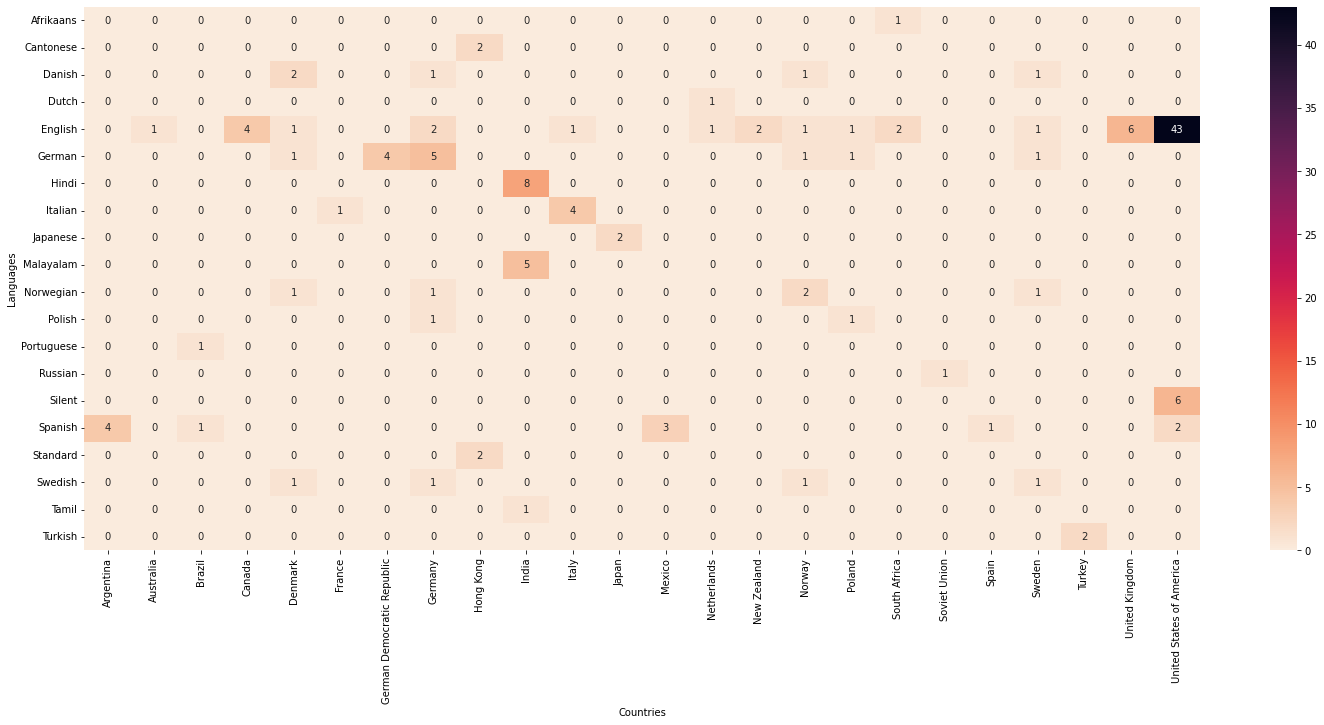

In [40]:
'''Compute the p-value'''
pvalue_language_country = pvalue_var1_var2(df_language_country, 'Languages', 'Countries')

In [41]:
print(f'The p-value for H0: "languages and countries are independent" is {pvalue_language_country}.')

The p-value for H0: "languages and countries are independent" is 1.6730822642759347e-89.


We deduce that Languages and Countries are not independent variables. For future analysis, we may keep only one of these variables.

#### Languages vs Genres <a class="anchor" id="sub_section_4_2_2"></a>

  Languages             Genres
0   English           Thriller
1   English    Science Fiction
2   English             Horror
3   English          Adventure
4   English       Supernatural
5   English             Action
6   English      Space western
7   English            Mystery
8   English  Biographical film
9   English              Drama


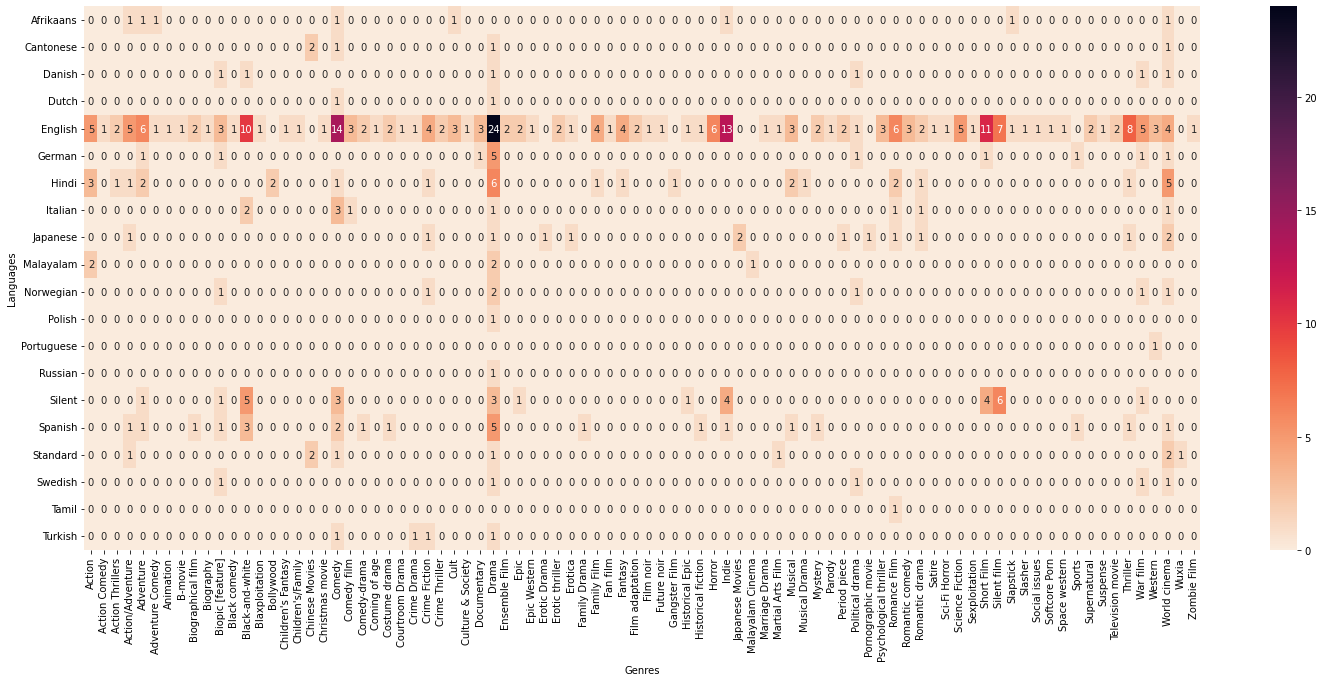

In [42]:
df_language_genre = data_formatting('Languages', 'Genres')
pvalue_language_genre = pvalue_var1_var2(df_language_genre, 'Languages', 'Genres')

In [43]:
print(f'The p-value for H0: "languages and genres are independent" is {pvalue_language_genre}.')

The p-value for H0: "languages and genres are independent" is 0.9999999999999998.


We deduce that Languages and Genres are independent variables.

#### Countries vs Genres <a class="anchor" id="sub_section_4_2_3"></a>

                  Countries             Genres
0  United States of America           Thriller
1  United States of America    Science Fiction
2  United States of America             Horror
3  United States of America          Adventure
4  United States of America       Supernatural
5  United States of America             Action
6  United States of America      Space western
7  United States of America            Mystery
8  United States of America  Biographical film
9  United States of America              Drama


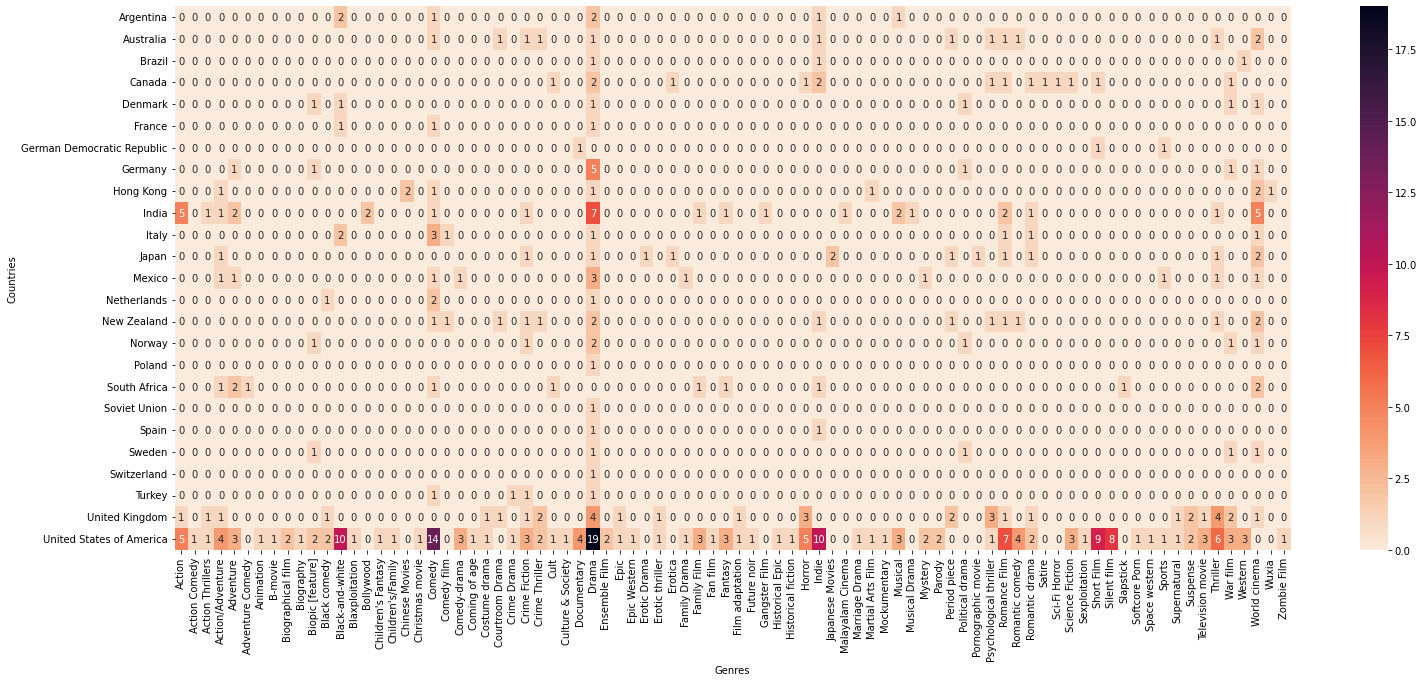

In [44]:
df_country_genre = data_formatting('Countries', 'Genres')
pvalue_country_genre = pvalue_var1_var2(df_country_genre, 'Countries', 'Genres')

In [45]:
print(f'The p-value for H0: "countries and genres are independent" is {pvalue_country_genre}.')

The p-value for H0: "countries and genres are independent" is 1.0.


We deduce that Countries and Genres are independent variables.

Our plan for the future analysis of the data is described in the `README` file.